# Analyse des données du Vendée Globe 2020-2021

## Corrigé partiel

Ce corrigé partiel illustre un certain nombre de points du projet.

**Commentaires** :
- Ce corrigé fournit également des commentaires généraux sur la manière dont les sujets ont été abordés dans les différents projets remis.
- Le degré de rédaction et de commentaire des projets est assez hétérogène.
    - Il faut structurer son document (titre, plan et paragraphes), rédiger sur la méthodologie employée et expliquer ou commenter les résultats obtenus.
    - Il faut également commenter son code.
    - S'inspirer aussi des recommandations d'usage pour l'écriture du code Python qui sont consignées dans la PEP 8 : https://www.python.org/dev/peps/pep-0008/
    - Il existe également un ordre convetionnel des imports à respecter : Python Standard Librairy, PyPI, autres packages.
    - Il faut également faire le ménage en supprimant les imports inutiles (librairies, classes ou fonctions non utilisées), ainsi que les instructions d'installation de librairies depuis le notebook (<code>!pip install ...</code>) qui peuvent potentiellement modifier l'environnement Python.
    
**Plan**

0. Collecte des fichiers Excel
1. Chargement des données
2. Préparation des données
3. Corrélation entre le classement et la vitesse utile et impact du foil
4. Visualisation de la distance parcourue par voilier et par jour
5. Quelques cartes
6. Méthodes statistiques et machine learning
7. Dashboard avec <code>Voilà</code>

*Nota bene* : les widgets qui ne s'affichent pas dans le notebook HTML ont été exportés à part afin d'en donner un aperçu, mais ils demeurent statiques.

In [1]:
# imports
import glob

# locale
import locale
import os
if os.name =='posix':
    lang = 'fr_FR.UTF-8'
elif os.name =='nt':
    lang = 'fr'
else:
    lang = 'fr_FR'
locale.setlocale(locale.LC_ALL, lang)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

### 0. Collecte des fichiers Excel

Les données du Vendée Globe sont disponibles sous la forme de fichiers Excel fournis quotidiennement et en général 6 fois par jour par les organisateurs de la course (https://www.vendeeglobe.org/fr/classement).

On collecte les fichiers Excel manquants par analyse de la page web relative au classement.

Les fichiers Excel sont ensuite sauvegardés dans un répertoire local `data`.

**Commentaires** :
- Certains projets ont effectué des calculs compliqués pour générer automatiquement les noms des fichiers Excel afin de les récupérer.
    - Il suffisait de scraper le menu déroulant de la page des classements. De plus, rien ne garantit que les heures utilisées dans les noms des fichiers restent à l'identique pendant toute la course.
- La plupart des projets soumis sauvegardent les données obtenues au format pickle et ont même fourni un fichier pickle dans leur repo github.
    - Pour mémoire, les fichiers pickle ne sont pas pérennes car ils sont généralement inutilisables d'une version de `pandas` à l'autre. Il vaut mieux utiliser soit le format textuel CSV, soit un format binaire comme HDF5 ou Parquet.
- Certains projets ont complètement occulté la manière dont ils avaient collecté les fichiers Excel.
    - Il s'agissait d'un point important dans la partie sur l'acquisition des données.

In [2]:
# Collecte des fichiers Excel manquants

# imports
import os
import shutil

import requests
from urllib import request
from urllib.error import HTTPError
from bs4 import BeautifulSoup

r = requests.get('https://www.vendeeglobe.org/fr/classement')
soup = BeautifulSoup(r.content)
flag = False

for tag_option in soup.findAll('option'):
    
    # date du fichier Excel
    date = tag_option.attrs['value']
    
    if date == '':
        continue
        
    filename = f'data/vendeeglobe_{date}.xlsx'
    # on vérifie que l'on n'a pas déjà collecté le fichier
    if os.path.exists(filename):
        continue
        
    print(filename)
    try:
        url = f'https://www.vendeeglobe.org/download-race-data/vendeeglobe_{date}.xlsx'
        with request.urlopen(url) as response, open(filename, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
            print('write', filename)
        flag = True
        
    except HTTPError as exception:
        print(f'erreur HTTP: {url}')
        
if not flag:
    print('aucun nouveau fichier trouvé')

aucun nouveau fichier trouvé


### 1. Chargement des données

#### 1.1 Données de la course

On charge toutes les données Excel dans un DataFrame unique :
- On conserve les 20 colonnes utiles des fichiers sources.
- On rajoute une colonne nommée 'date' avec la partie "timestamp" du nom de chaque fichier.
- On supprime toutes les lignes dont le rang n'est pas un entier dans les fichiers sources.

**Commentaires** :
- Il semble qu'il y ait bien un bug avec la version récente de `pandas` pour la lecture des fichiers Excel qui s'appuie à présent sur la librairie `openpyxl` et non plus sur `xlrd`. Les versions récentes de `xlrd` sont uniquement capables de charger les fichiers "XSL" et non "XLSX". Le notebook initial fonctionne avec l'ancienne version de `pandas` 1.2.4 et `xlrd` 1.2.0.
- Une mise à jour du notebook a été effectuée avec l'utilisation de la librairie `xlwings` lorsque c'est nécessaire, comme cela a été fait par certains projets remis. Le chargement des 700 fichiers prend environ 1 minute avec `pandas` seul et environ 10 minutes via `xlwings`.
    - Il vaut mieux laisser les fichiers originaux intacts et utiliser des fichiers temporaires ou un répertoire tampon pour la lecture/écriture avec `xlwings`. Il est effectivement préférable de conserver les données brutes et il est possible qu'à terme la librairie `openpyxl` parvienne à lire ces fichiers.
- Il était possible de spécifier les valeurs "RET" (retrait ou abandon) et "NL" (non localisé) comme étant des "NaN" pour s'en débarrasser par la suite.
- Le chargement de tous les DataFrames dans une liste pour ensuite obtenir un DataFrame unique est plus efficace que la concaténation des DataFrames au fur et à mesure.
- On gagne aussi en efficacité en effectuant toutes les transformations d'un coup et non fichier par fichier, en essayant d'effectuer ensuite des transformations ou des calculs vectoriels.
- Certains projets ont conservé les noms des colonnes des fichiers Excel - qui étaient bilingues - et ont parfois même reproduit un index multiple pour les noms des colonnes.
    - Ne pas hésiter à simplifier les noms des colonnes lorsque c'est nécessaire et aussi afin d'augmenter la lisibilité du code et la productivité du data scientist.
    - Ne pas complexifier inutilement les données en tentant de reproduire leur schéma initial.
- Certains projets ont effectué des manipulations compliquées en créant manuellement un DataFrame par skipper, éventuellement enregistré dans une variable du nom du skipper, pour ensuite les alimenter au fur et à mesure à partir des fichiers Excel.
    - Dans la mesure du possible il faut utiliser les manipulations apportées par `pandas` qui permettent une automatisation et une vectorisation de tous les traitements.
    - Il faut également imaginer d'autres cas d'usage et penser à la réutilisation du code :
        - Quid du code pour une autre course de voiliers et avec d'autres skippers ? Par exemple, le code existant fonctionne avec relativement peu de modifications pour la Solitaire du Figaro (voir https://www.lasolitaire.com).
        - Quid d'un DataFrame par coureur pour le Marathon de New York ?

In [3]:
# chargement des données

# imports
import uuid

import xlwings as xw
from tqdm import tqdm


# lecture/écriture d'un fichier Excel avec xlwings
def save_with_xlwings(file):
    tempfile = './{uuid.uuid1()}.xlsx'
    excel_app = xw.App(visible=False)
    excel_book = excel_app.books.open(file)
    excel_book.save(tempfile)
    excel_book.close()
    excel_app.quit()

    return tempfile


# lecture des fichiers Excel
# on gère les erreurs de openpyxl
# on gère également la modification du format en fin de course
def read_excelfile(file):
    tempfile = ''
    
    # lecture standard
    try:
        df = pd.read_excel(file, skiprows=4, skipfooter=4, na_values=['NL', 'RET'])
    except TypeError:
        tempfile = save_with_xlwings(file)
        df = pd.read_excel(tempfile, skiprows=4, skipfooter=4, na_values=['NL', 'RET'])

    # test arrivés
    test = df.iloc[:, 1].astype(str).str.endswith('ARV').any()
    if test:
        n = df.iloc[:, 1].astype(str).str.endswith('ARV').sum()
        try:
            df = pd.read_excel(file, skiprows=n+6, skipfooter=4, na_values=['NL', 'RET'])
        except TypeError:
            df = pd.read_excel(tempfile, skiprows=n+6, skipfooter=4, na_values=['NL', 'RET'])
            
    if os.path.exists(tempfile):
        os.remove(tempfile)
        
    df = df.iloc[:, 0:21]

    return df
        

def load_course_data(read_pickle=True):
    
    if read_pickle and os.path.exists('data/vendeeglobe.pkl'):
        df = pd.read_pickle('data/vendeeglobe.pkl')
        return df
    
    files = glob.glob('data/*.xlsx')
    files = [file for file in files if file.find('~') == -1]
    files.sort()

    dfs = []
    
    for file in tqdm(files):
        
        df = read_excelfile(file)
    
        #print(file, df.columns)
        
        # colonne A vide
        df = df.drop(df.columns[0], axis=1)
        
        # renommage des colonnes
        df.columns = ['rang', 'nat_voile', 'skipper_bateau',
                      'heure', 'latitude', 'longitude',
                      'cap', 'vitesse', 'VMG', 'distance',
                      'cap1', 'vitesse1', 'VMG1', 'distance1',
                      'cap2', 'vitesse2', 'VMG2', 'distance2',
                      'DTF', 'DTL']
        
        # timestamp dans le nom du fichier
        df['date'] = file[-20:-5]

        dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)
    
    df = df.loc[df['rang'].notnull()]
    df['rang'] = df['rang'].astype(int)
    
    df.to_pickle('data/vendeeglobe.pkl')
    
    return df

df_course = load_course_data()

In [4]:
df_course.head()

,rang,nat_voile,skipper_bateau,heure,latitude,longitude,cap,vitesse,VMG,distance,...,vitesse1,VMG1,distance1,cap2,vitesse2,VMG2,distance2,DTF,DTL,date
0,1,\nFRA 18,Louis Burton\nBureau Vallée 2,15:30 FR\n,46°24.46'N,01°50.48'W,241°,17.7 kts,17.5 kts,0.3 nm,...,0.0 kts,0.0 kts,2788.0 nm,201°,0.3 kts,0.3 kts,6.1 nm,24293.9 nm,0.0 nm,20201108_140000
1,2,\nMON 10,Boris Herrmann\nSeaexplorer - Yacht Club De Mo...,15:31 FR\n1min,46°24.34'N,01°49.82'W,241°,11.1 kts,10.9 kts,0.4 nm,...,0.0 kts,0.0 kts,2787.9 nm,196°,0.3 kts,0.2 kts,6.0 nm,24294.2 nm,0.4 nm,20201108_140000
2,3,\nFRA 8,Jérémie Beyou\nCharal,15:30 FR\n,46°24.91'N,01°49.99'W,244°,15.5 kts,15.5 kts,0.5 nm,...,0.0 kts,0.0 kts,2788.5 nm,199°,0.2 kts,0.2 kts,5.5 nm,24294.3 nm,0.5 nm,20201108_140000
3,4,\nFRA 59,Thomas Ruyant\nLinkedOut,15:30 FR\n,46°24.71'N,01°49.68'W,244°,13.2 kts,13.1 kts,0.7 nm,...,0.0 kts,0.0 kts,2788.3 nm,196°,0.2 kts,0.2 kts,5.6 nm,24294.5 nm,0.6 nm,20201108_140000
4,5,\nFRA 53,Maxime Sorel\nV And B Mayenne,15:30 FR\n,46°24.59'N,01°49.56'W,246°,10.9 kts,10.9 kts,0.2 nm,...,0.0 kts,0.0 kts,2788.1 nm,195°,0.8 kts,0.7 kts,5.8 nm,24294.5 nm,0.6 nm,20201108_140000


#### 1.2 Données relatives aux voiliers

Le site du Vendée Globe comporte une page web avec des informations techniques sur les voiliers : Numéro de voile, Anciens noms du bateau, Architecte, Chantier, Date de lancement, Longueur, Largeur, Tirant d'eau, Déplacement (poids), Nombre de dérives, Hauteur mât, Voile quille, Surface de voiles au près, Surface de voiles au portant (https://www.vendeeglobe.org/fr/glossaire).

- On récupère les noms des bateaux et des skippers qui sont dans le même ordre que les fiches des voiliers.
- On charge les données supplémentaires dans un autre DataFrame.

**Commentaires** :
- Dans certains projets, le scraping des données a été assez laborieux.
    - Il était possible de collecter 1) les noms des voiliers, 2) les noms des skippeurs 3) les différents attributs et leurs valeurs respectives.
- D'autres projets n'ont pas tenu compte de cette seconde source de données.
    - Il s'agissait d'un autre point important dans la partie sur la collecte des données.

In [5]:
# Chargement des fiches des voiliers

# import
import re

# remove extra spaces + title
def clean_text(text, title=True):
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    if title:
        text = text.title()
    return text

def load_voiliers_data():
    
    # chargement de la page glossaire
    r = requests.get('https://www.vendeeglobe.org/fr/glossaire')
    soup = BeautifulSoup(r.content)
    
    rows = []
    
    # recherche des tags h3, class="boats-list__skipper-name"
    # on crée un dictionnaire par voilier
    for span_tag in soup.findAll('h3', {'class': 'boats-list__boat-name'}):
        rows.append({'boat-name': clean_text(span_tag.text)})
        
    # recherche des tags span, class="boats-list__skipper-name"
    for i, span_tag in enumerate(soup.findAll('span', {'class': 'boats-list__skipper-name'})):
        row = rows[i]
        
        # pour faciliter la comparaison ensuite on effectue un peu de nettoyage ici
        row['skipper-name'] = clean_text(span_tag.text)
    
    # recherche des tags h3, class='boats-list__popup-title'
    for i, h3_tag in enumerate(soup.findAll('h3', {'class': 'boats-list__popup-title'})):
        row = rows[i]
        
        # recherche des sous-tags li
        for li_tag in h3_tag.parent.findAll('li'):
            key, value = li_tag.text.split(':', 1)
            row[key.strip()] = clean_text(value, False)

    df = pd.DataFrame(rows)
    
    return df

df_voiliers = load_voiliers_data()

In [6]:
df_voiliers.head()

,boat-name,skipper-name,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,Newrest - Art & Fenêtres,Fabrice Amedeo,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2
1,Pure - Best Western®,Romain Attanasio,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2
2,Tse - 4Myplanet,Alexia Barrier,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2
3,Maître Coq Iv,Yannick Bestaven,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2
4,Charal,Jérémie Beyou,08,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2


### 2. Préparation des données

#### 2.1 Données de la course

On prépare les données :
- On teste les valeurs uniques pour se rendre compte qu'il y a une valeur en trop dans la colonne 'skipper_bateau' due à la casse des chaînes de caractère.
- On passe en nombres flottants les 14 colonnes représentant des grandeurs numériques : 'cap', 'vitesse', 'VMG', 'distance', 'cap1', 'vitesse1', 'VMG1', 'distance1', 'cap2', 'vitesse2', 'VMG2', 'distance2', 'DFT', 'DTL'
- On passe la colonne 'date' initalement 'str' en objet de type 'datetime'
- On reformate la colonne 'nat_voile' de sorte à ne conserver que la nationalité (ISO3) suivi d'un ou plusieurs caractères numériques. Par exemple: 'FRA02'.
- On passe les colonnes 'latitude' et 'longitude' en degrés représentés par des nombres flottants. Concernant ces données, sous la forme `46°24.46'N` par exemple, il s'agit ici des degrés de latitude ou de longitude, suivis par des minutes en nombre décimal limité au centième, et non par les minutes suivies par les secondes. Il est possible de le vérifier en extrayant tous les nombres entre le point `.` et l'apostrophe `'` et en constatant qu'il y a exactement 100 valeurs distinctes, soit de `00` à `99`.

**Commentaires** :
- Dans plusieurs projets, le traitement des valeurs numériques a été assez laborieux.
    - Il était possible de s'en tirer en une seule instruction valable pour toutes les colonnes numériques sans se préoccuper des unités indiquées en suffixe.
- Certains projets ont cherché à utiliser la donnée temporelle supplémentaire de la colonne "heure".
    - Bravo !
- Pour la latitude et la longitude, plusieurs projets ont considéré que la valeur décimale des minutes était des secondes et ont donc divisé cette grandeur par 3600.
    - Il ne faut pas hésiter à effectuer des tests pour vérifier certaines hypothèses.
    - Quelques projets ont utilisé les librairies `dataprep` (1k &star; sur github)  ou `lat_lon_parser` (6 &star; sur github) pour convertir les coordonnées. Ces librairies semblent fournir les résultats corrects. Il faut cependant se méfier des micro-librairies trouvées sur PyPI (très peu de stars sur github), tout comme du code trouvé sur Stack Overflow ou autre. Les étudiants qui ont utilisé la librairie `dms2dec` de PyPI ont eu moins de chance, elle ne fournit pas les bons résultats avec les données.
    - Certains projets ont utilisé des `split()` en cascade pour extraire les différentes valeurs d'angle. Cela donne un code peu lisible peu maintenable et peu efficace. Ne pas hésiter à utiliser des expressions régulières avec notamment `extract()`.

Test du nombre de valeurs uniques de chaque colonne. La colonne 'skipper_bateau' comporte une valeur de trop.

In [7]:
# nunique sur les colonnes
df_course.nunique()

rang                 33
nat_voile            33
skipper_bateau       34
heure                45
latitude          14918
longitude         15035
cap                 360
vitesse             239
VMG                 300
distance            142
cap1                354
vitesse1            231
VMG1                279
distance1          1318
cap2                318
vitesse2            213
VMG2                247
distance2          3594
DTF               14736
DTL               11669
date                701
dtype: int64

In [8]:
# valeurs uniques de skipper_bateau
sorted(df_course['skipper_bateau'].unique())

['Alan Roura\nLa Fabrique',
 'Alex Thomson\nHUGO BOSS',
 'Alex Thomson\nHugo Boss',
 'Alexia Barrier\nTSE - 4myplanet',
 'Ari Huusela\nStark',
 "Armel Tripon\nL'Occitane en Provence",
 'Arnaud Boissieres\nLa Mie Câline - Artisans Artipôle',
 'Benjamin Dutreux\nOMIA - Water Family',
 'Boris Herrmann\nSeaexplorer - Yacht Club De Monaco',
 'Charlie Dalin\nAPIVIA',
 'Clarisse Cremer\nBanque Populaire X',
 'Clément Giraud\nCompagnie du lit - Jiliti',
 'Damien Seguin\nGroupe APICIL',
 'Didac Costa\nOne Planet One Ocean',
 'Fabrice Amedeo\nNewrest - Art et Fenetres',
 'Giancarlo Pedote\nPrysmian Group',
 'Isabelle Joschke\nMACSF',
 'Jean Le Cam\nYes we Cam !',
 'Jérémie Beyou\nCharal',
 'Kevin Escoffier\nPRB',
 'Kojiro Shiraishi\nDMG MORI Global One',
 'Louis Burton\nBureau Vallée 2',
 'Manuel Cousin\nGroupe Sétin',
 'Maxime Sorel\nV And B Mayenne',
 'Miranda Merron\nCampagne de France',
 "Nicolas Troussel\nCORUM L'Épargne",
 'Pip Hare\nMedallia',
 'Romain Attanasio\nPure - Best Western Hotel

Tests des valeurs de latitude et de longitude.

In [9]:
# test latitudes : NS

df_course['latitude'].str.extract("'(.*)$", expand=False).unique()

array(['N', 'S'], dtype=object)

In [10]:
# test latitudes : degrés, minutes, centièmes de minutes, N ou S

df_course['latitude'].str.extract("^(\d+)°(\d+)\.(\d+)'([NS])$").nunique()

0     59
1     60
2    100
3      2
dtype: int64

In [11]:
# test longitudes : EW

df_course['longitude'].str.extract("'(.*)$", expand=False).unique()

array(['W', 'E'], dtype=object)

In [12]:
# test longitudes : degrés, minutes, centièmes de minutes, E ou W

df_course['longitude'].str.extract("^(\d+)°(\d+)\.(\d+)'([EW])$").nunique()

0    180
1     61
2    100
3      2
dtype: int64

In [13]:
# préparation des données

def prep_course_data(df):

    # col numériques : on conserve les caractères numériques et le .
    for col in ['cap', 'vitesse', 'VMG', 'distance',\
                'cap1', 'vitesse1', 'VMG1', 'distance1',\
                'cap2', 'vitesse2', 'VMG2', 'distance2',\
                'DTF', 'DTL']:
        df[col] = df[col].str.extract('([\d\.]+)', expand=False).astype(float)

    # dates
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d_%H%M%S')

    # nat_voile
    tab = df['nat_voile'].str.extract('([A-Z]{3})\s*(\d+)')
    df['nat_voile'] = tab[0] + tab[1]
    
    # skipper_bateau, en particulier : HUGO BOSS => Hugo Boss
    df['skipper_bateau'] = df['skipper_bateau'].str.title()
    df[['skipper', 'bateau']] = df['skipper_bateau'].str.split('\n', expand=True)
    
    # latitude
    tab = df['latitude'].str.extract("(\d+)°([\d\.]+)'([NS])")  # degrés, minutes, N ou S
    df['latitude'] = (tab[0].astype(float) + tab[1].astype(float)/60) * tab[2].map({'N': 1, 'S': -1})

    # longitude
    tab = df['longitude'].str.extract("(\d+)°([\d\.]+)'([EW])")  # degrés, minutes, E ou W
    df['longitude'] = (tab[0].astype(float) + tab[1].astype(float)/60) * tab[2].map({'E': 1, 'W': -1})
    
    # couleurs pour les graphiques
    skippers = df['skipper'].unique().tolist()
    skippers.sort()
    colors = (cm.tab20.colors + cm.tab20b.colors)[:len(skippers)]
    mapping = dict(zip(skippers, colors))
    df['color'] = df['skipper'].map(mapping)
    
    return df

df_course = prep_course_data(df_course)

In [14]:
# nunique sur les colonnes
df_course.nunique()

rang                 33
nat_voile            33
skipper_bateau       33
heure                45
latitude          14918
longitude         15035
cap                 360
vitesse             239
VMG                 234
distance            142
cap1                354
vitesse1            231
VMG1                225
distance1          1318
cap2                318
vitesse2            213
VMG2                212
distance2          3594
DTF               14736
DTL               11669
date                701
skipper              33
bateau               33
color                33
dtype: int64

In [15]:
df_course.head()

,rang,nat_voile,skipper_bateau,heure,latitude,longitude,cap,vitesse,VMG,distance,...,cap2,vitesse2,VMG2,distance2,DTF,DTL,date,skipper,bateau,color
0,1,FRA18,Louis Burton\nBureau Vallée 2,15:30 FR\n,46.407667,-1.841333,241.0,17.7,17.5,0.3,...,201.0,0.3,0.3,6.1,24293.9,0.0,2020-11-08 14:00:00,Louis Burton,Bureau Vallée 2,"(0.2235294117647059, 0.23137254901960785, 0.47..."
1,2,MON10,Boris Herrmann\nSeaexplorer - Yacht Club De Mo...,15:31 FR\n1min,46.405667,-1.830333,241.0,11.1,10.9,0.4,...,196.0,0.3,0.2,6.0,24294.2,0.4,2020-11-08 14:00:00,Boris Herrmann,Seaexplorer - Yacht Club De Monaco,"(1.0, 0.596078431372549, 0.5882352941176471)"
2,3,FRA8,Jérémie Beyou\nCharal,15:30 FR\n,46.415167,-1.833167,244.0,15.5,15.5,0.5,...,199.0,0.2,0.2,5.5,24294.3,0.5,2020-11-08 14:00:00,Jérémie Beyou,Charal,"(0.8588235294117647, 0.8588235294117647, 0.552..."
3,4,FRA59,Thomas Ruyant\nLinkedout,15:30 FR\n,46.411833,-1.828000,244.0,13.2,13.1,0.7,...,196.0,0.2,0.2,5.6,24294.5,0.6,2020-11-08 14:00:00,Thomas Ruyant,Linkedout,"(0.9058823529411765, 0.796078431372549, 0.5803..."
4,5,FRA53,Maxime Sorel\nV And B Mayenne,15:30 FR\n,46.409833,-1.826000,246.0,10.9,10.9,0.2,...,195.0,0.8,0.7,5.8,24294.5,0.6,2020-11-08 14:00:00,Maxime Sorel,V And B Mayenne,"(0.4196078431372549, 0.43137254901960786, 0.81..."


Aucune colonne avec un NaN

In [16]:
# test colonnes avec NaN
test = df_course.isnull().sum()
test[test != 0]

Series([], dtype: int64)

#### 2.2 Données des voiliers

Avant de préparer les données des voiliers, on effectue une comparaison avec celles de la course en vue de leur jointure.

On constate des écarts entre les données. On va effectuer la jointure des 2 DataFrames sur les prénoms et noms des skippers, dont 2 sont corigés manuellement : Arnaud Boissieres et Samantha Davies.

La présence d'un *foil* est indiquée dans la colonne "Nombre de dérives". On rajoute une colonne "foil" de type bool et une colonne "foil ?" valant "avec" ou "sans".

**Commentaires** :
- Un certain nombre de projets est passé à côté des écarts entre les noms de certains skippeurs ou des numéros de voile selon les 2 sources de données.
    - Là encore, il ne faut pas hésiter à effectuer des tests pour vérifier certaines hypothèses ou tester la cohérence des jeux de données.
- Certains projets ont effectué des manipulations complexes pour transformer les colonnes utilisées pour effectuer la jointure entre les 2 sources de données.
    - Les modifications à apporter pour la jointure selon les noms des skippers sont plus simples que pour les voiles.
    - A partir d'un certain niveau de transformations, il vaut mieux effectuer des remplacements manuels ou utiliser un mapping de valeurs produit manuellement, plutôt qu'implémenter des fonctions *ad hoc* peu lisibles, peu maintenables et peu réutilisables.

Alignement des skippers, des noms des voiliers et des numéros de voile des 2 sources et visualisation des écarts. Un certain nombre d'écarts provient des accents, de la ponctuation, d'abbréviations, etc.

In [17]:
# alignement skippers, voiliers et n° de voile

# highlight des cellules contiguës avec des valeurs différentes
def highlight_diff(row):
    # liste = [0, 0, 2, 2, 4, 4]
    l = [int(i / 2) * 2 for i in range(len(row))]
    return ['background-color: yellow' if row[i] != row[i + 1] else '' for i in l]

# df_course : skipper, bateau, nat_voile
tab1 = df_course[['skipper', 'bateau', 'nat_voile']].drop_duplicates().sort_values('skipper')

# df_voiliers : skipper-name, boat-name, Numéro de voile
tab2 = df_voiliers[['skipper-name', 'boat-name', 'Numéro de voile']].sort_values('skipper-name')

# concat et ordre des colonnes
tab = pd.concat([tab1.reset_index(drop=True), tab2.reset_index(drop=True)], axis=1)
tab = tab[['skipper', 'skipper-name', 'bateau', 'boat-name', 'nat_voile', 'Numéro de voile']]

# stylization
tab = tab.style.apply(highlight_diff, axis=1)
tab

,skipper,skipper-name,bateau,boat-name,nat_voile,Numéro de voile
0,Alan Roura,Alan Roura,La Fabrique,La Fabrique,SUI7,SUI07
1,Alex Thomson,Alex Thomson,Hugo Boss,Hugo Boss,GBR99,GBR 99
2,Alexia Barrier,Alexia Barrier,Tse - 4Myplanet,Tse - 4Myplanet,FRA72,FRA72
3,Ari Huusela,Ari Huusela,Stark,Stark,FIN222,FIN222
4,Armel Tripon,Armel Tripon,L'Occitane En Provence,L'Occitane En Provence,FRA02,2
5,Arnaud Boissieres,Arnaud Boissières,La Mie Câline - Artisans Artipôle,La Mie Câline - Artisans Artipôle,FRA14,FRA 14
6,Benjamin Dutreux,Benjamin Dutreux,Omia - Water Family,Omia - Water Family,FRA09,FRA09
7,Boris Herrmann,Boris Herrmann,Seaexplorer - Yacht Club De Monaco,Seaexplorer - Yacht Club De Monaco,MON10,16
8,Charlie Dalin,Charlie Dalin,Apivia,Apivia,FRA79,FRA 79
9,Clarisse Cremer,Clarisse Cremer,Banque Populaire X,Banque Populaire X,FRA30,FRA30


In [18]:
# préparation des données des voiliers

def prep_voiliers_data(df):
   
    for col in ['Longueur', 'Largeur', 'Tirant d\'eau', 'Déplacement (poids)',
                'Hauteur mât', 'Surface de voiles au près', 'Surface de voiles au portant']:

        # Extraction des nombres
        df[col] = df[col].fillna('')
        df[col] = df[col].str.extract('([\d,]+)', expand=False)
        df[col] = df[col].replace(',', '.', regex=True)
        df[col] = df[col].replace('', np.nan)
        df[col] = df[col].replace('NC', np.nan)
        df[col] = df[col].replace('nc', np.nan)
        df[col] = df[col].astype(float)
    
    # skipper-name
    df['skipper-name'] = df['skipper-name'].replace('Arnaud Boissières', 'Arnaud Boissieres')
    df['skipper-name'] = df['skipper-name'].replace('Sam Davies', 'Samantha Davies')
    
    # foils
    df['foil'] = df['Nombre de dérives'].str.contains('foil')
    df['foil ?'] = df['foil'].apply(lambda x: 'avec' if x else 'sans')
    
    # pour préparer le merge avec un seul nom de colonne
    df = df.rename(columns={'skipper-name': 'skipper'})

    return df

df_voiliers = prep_voiliers_data(df_voiliers)

In [19]:
df_voiliers.head()

,boat-name,skipper,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant,foil,foil ?
0,Newrest - Art & Fenêtres,Fabrice Amedeo,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,18.28,5.85,4.5,7.0,foils,29.0,monotype,320.0,570.0,True,avec
1,Pure - Best Western®,Romain Attanasio,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,18.28,5.80,4.5,9.0,2,28.0,acier forgé,280.0,560.0,False,sans
2,Tse - 4Myplanet,Alexia Barrier,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,18.28,5.54,4.5,9.0,2,29.0,acier,260.0,580.0,False,sans
3,Maître Coq Iv,Yannick Bestaven,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,18.28,5.80,4.5,8.0,foils,29.0,acier mécano soudé,310.0,550.0,True,avec
4,Charal,Jérémie Beyou,08,NaN,VPLP,CDK Technologies,18 Août 2018,18.28,5.85,4.5,8.0,foils,29.0,acier,320.0,600.0,True,avec


Quelques colonnes avec des NaN. Il s'agit des caractéristiques absentes pour certains voiliers.

In [20]:
# test colonnes avec NaN
test = df_voiliers.isnull().sum()
test[test != 0]

Numéro de voile           1
Anciens noms du bateau    9
Déplacement (poids)       2
Voile quille              1
dtype: int64

#### 2.3 Jointure sur les données

Les données sont à présent prêtes à être fusionnées sur le nom des skippers.

Après fusion, on vérifie les colonnes qui comportent des NaN pour s'assurer qu'il n'y a pas eu de problème.

**Commentaires** :
- De rares projets n'ont pas effectué de jointure entre les 2 jeux de données.
    - C'est pourtant le seul moyen d'étudier, par exemple, l'impact du *foil* sur la course.

In [21]:
# merge des données sur le nom du skipper

def merge_data(df_course, df_voiliers):
    df = pd.merge(df_course, df_voiliers, on='skipper', how='left')
    df = df.sort_values(['date', 'rang'])
    return df

df_all = merge_data(df_course, df_voiliers)

In [22]:
df_all.head()

,rang,nat_voile,skipper_bateau,heure,latitude,longitude,cap,vitesse,VMG,distance,...,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant,foil,foil ?
0,1,FRA18,Louis Burton\nBureau Vallée 2,15:30 FR\n,46.407667,-1.841333,241.0,17.7,17.5,0.3,...,5.80,4.5,7.6,foils,28.0,acier,300.0,600.0,True,avec
1,2,MON10,Boris Herrmann\nSeaexplorer - Yacht Club De Mo...,15:31 FR\n1min,46.405667,-1.830333,241.0,11.1,10.9,0.4,...,5.70,4.5,7.6,foils,29.0,acier,290.0,490.0,True,avec
2,3,FRA8,Jérémie Beyou\nCharal,15:30 FR\n,46.415167,-1.833167,244.0,15.5,15.5,0.5,...,5.85,4.5,8.0,foils,29.0,acier,320.0,600.0,True,avec
3,4,FRA59,Thomas Ruyant\nLinkedout,15:30 FR\n,46.411833,-1.828000,244.0,13.2,13.1,0.7,...,5.85,4.5,8.0,foils,29.0,acier forgé,350.0,560.0,True,avec
4,5,FRA53,Maxime Sorel\nV And B Mayenne,15:30 FR\n,46.409833,-1.826000,246.0,10.9,10.9,0.2,...,5.50,4.5,7.7,2,29.0,acier,365.0,700.0,False,sans


Les colonnes avec des NaN correspondent uniquement aux caractéristiques absentes de certains voiliers.

In [23]:
# test colonnes avec NaN
test = df_all.isnull().sum()
test[test != 0]

Numéro de voile            485
Anciens noms du bateau    3087
Déplacement (poids)        709
Voile quille                50
dtype: int64

### 3. Corrélation entre le classement et la vitesse utile et impact du foil

#### 3.1 Régression entre le classement et la vitesse utile

- On calcule la moyenne du classement (colonne "rang") et de la vitesse utile (colonne "VMG") de chaque voilier. On trace un graphique avec pour chaque voilier son classement moyen et sa vitesse utile moyenne.
- On observe une corrélation entre le classement et la vitesse utile.

**Commentaires** :
- Mettre systématiquement un titre aux graphiques produits.
- Certains projets ont annoté les points avec les n° de voile, très bonne idée !

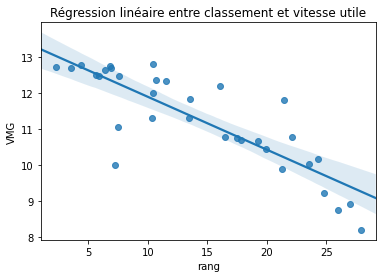

In [24]:
# Régression entre classement et vitesse utile

def regression_rang_vmg(df):
    tab = df.groupby('nat_voile')[['rang', 'VMG']].mean()
    fig, ax = plt.subplots()
    ax.set_title('Régression linéaire entre classement et vitesse utile')
    sns.regplot(x=tab['rang'], y=tab['VMG'], truncate=False, data=tab, ax=ax);
    
regression_rang_vmg(df_course)

#### 3.2 Impact du *foil* sur le classement et la vitesse utile

Le *foil* est une aile positionnée et profilée de façon à générer, par son déplacement dans l'eau, une force de portance qui agit sur sa vitesse et sa stabilité (source Wikipédia). Cette année dans le Vendée Globe, 19 voiliers étaient équipés d'un *foil*. Nous allons calculer l'impact du *foil* sur le classement et la vitesse utile.
 
- On trace un graphique avec les caractéristiques du classement et de la vitesse utile selon l'existence d'un *foil*. Les voiliers avec un *foil* ont un meilleur classement et une vitesse utile plus élevée
- On trace un graphique avec pour chaque voilier son classement moyen et sa vitesse utile moyenne selon l'existence d'un *foil*.

Au final, on observe une plus grande dispersion de la vitesse avec *foil* que sans. C'est peut-être dû au fait que les voiliers avec *foil* ont plus de chance de rencontrer des "OFNI", voir : https://www.vendeeglobe.org/fr/actualites/10367/le-mot-du-jour-ofni.

**Commentaires** :
- Certains projets ont laissé les valeurs brutes dans les graphiques (booléens, index...).
    - Ne pas hésiter à remplacer les valeurs brutes par des libellés explicites, des formatages plus lisibles, et en cohérence avec la langue utilisée, etc.

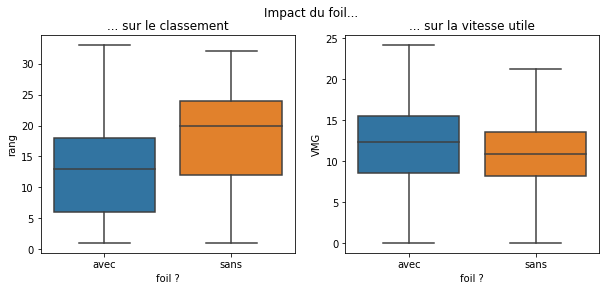

In [25]:
# moyenne_rang_vmg_foil

def impact_foil(df):
    fig = plt.figure(figsize=(10, 4))
    fig.suptitle('Impact du foil...')
    ax1 = fig.add_subplot(121)
    ax1.set_title('... sur le classement')
    sns.boxplot(x='foil ?', y='rang', data=df, ax=ax1)
    ax2 = fig.add_subplot(122)
    ax2.set_title('... sur la vitesse utile')
    sns.boxplot(x='foil ?', y='VMG', data=df, ax=ax2)

impact_foil(df_all)

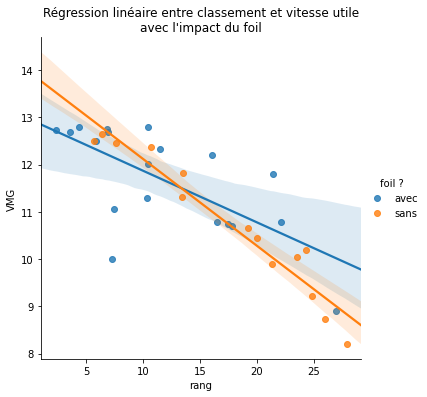

In [26]:
# Régression linéaire entre classement et vitesse utile avec l'impact du foil

def regression_rang_VMG_foil(df):
    # on calcule la moyenne par skipper
    # la colonne foil est un bool constant par skipper
    tab = df.groupby('skipper')[['rang', 'VMG', 'foil']].mean()
    tab['foil ?'] = tab['foil'].apply(lambda x: 'avec' if x else 'sans')
    lm = sns.lmplot(x='rang', y='VMG', hue='foil ?', truncate=False, data=tab)
    ax = lm.axes[0][0]
    ax.set_title('Régression linéaire entre classement et vitesse utile\navec l\'impact du foil');
    
regression_rang_VMG_foil(df_all)

#### 3.3 Calcul de l'impact du *foil* sur les données numériques de la course

- On trace un graphique interactif avec l'impact du *foil* :
    - sur les différentes valeurs numériques
    - en calculant différents agrégats : count, mean, std, min, 25%, 50%, 75% et max
    - et en prenant comme échelle soit le temps (date) soit la distance (DTF).

Il semble que la présence d'un *foil* a un impact sur la plupart des valeurs numériques. A noter que l'assiette de calcul des moyennes change au fil du temps à cause des abandons (qui sont surtout du fait des voiliers à *foils*).

In [27]:
# impact du foil sur les colonnes numériques de df_course

# imports
from pandas.api.types import is_numeric_dtype
import matplotlib.dates as mdates
import ipywidgets as widgets

def impact_foil_on_column(col, aggfunc, scale):
    
    # cas où col = scale = DTF => pas de graphique
    if col == scale == 'DTF':
        print('pas de graphique')
        return None

    # selection et tri
    tab = df_all[[scale, 'foil ?', col]].sort_values(scale)

    # DTF arrondies aux centaines pour calculer les moyennes
    if scale == 'DTF':
        tab[scale] = tab[scale].apply(lambda x: round(x, -2))

    # 1. groupby
    tab = tab.groupby([scale, 'foil ?'])
    # 2. aggfunc
    if aggfunc == 'count':
        tab = tab.count()
    elif aggfunc == 'mean':
        tab = tab.mean()
    elif aggfunc == 'std':
        tab = tab.std()
    elif aggfunc == 'min':
        tab = tab.min()
    elif aggfunc == '25%':
        tab = tab.quantile(.25)
    elif aggfunc == '50%':
        tab = tab.median()
    elif aggfunc == '75%':
        tab = tab.quantile(.75)
    elif aggfunc == 'max':
        tab = tab.max()
    else:
        raise(f'Unknown aggfunc: {aggfunc}')
    # 3. reshape
    tab = tab.unstack().droplevel(0, axis=1)

    # plot
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(f'Impact du foil sur la colonne "{col}" ({aggfunc})')
    ax.set_xlabel(scale)
    ax.set_ylabel(f'{col} ({aggfunc})')
    
    dates = tab.index
    flag = tab['avec'] >= tab['sans']
    
    ax.plot(dates, tab['avec'], label='avec foil')
    ax.plot(dates, tab['sans'], label='sans foil')
    ax.fill_between(dates, tab['avec'], tab['sans'], flag, alpha=0.5)
    ax.fill_between(dates, tab['sans'], tab['avec'], ~flag, alpha=0.5)
    ax.legend()

    # axe des x
    if scale == 'date':
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
    else:
        ax.invert_xaxis()
    
# colonnes numériques
num_cols = [col for col in df_course.columns if is_numeric_dtype(df_all[col])]

# dropdown columns
column = widgets.Dropdown(options=num_cols,
                            value='VMG',
                            description='Colonne :',
                           )
# dropdown aggfunc
aggfunc = widgets.Dropdown(options=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'],
                             value='mean',
                             description='Agrégation :'
                            )

# radio button scale
scale = widgets.RadioButtons(options=['date', 'DTF'],
                             value='date',
                             description='Echelle :'
                            )

# interaction
widgets.interact(impact_foil_on_column, col=column, aggfunc=aggfunc, scale=scale);

interactive(children=(Dropdown(description='Colonne :', index=5, options=('rang', 'latitude', 'longitude', 'ca…

### 4. Visualisation de la distance quotidienne parcourue par voilier

Visualisation de la distance quotidienne parcourue par voilier :
- On calcule un tableau croisé avec pour chaque jour et chaque voilier la DTF maximum.
- On tri le tableau en fonction du dernier classement.

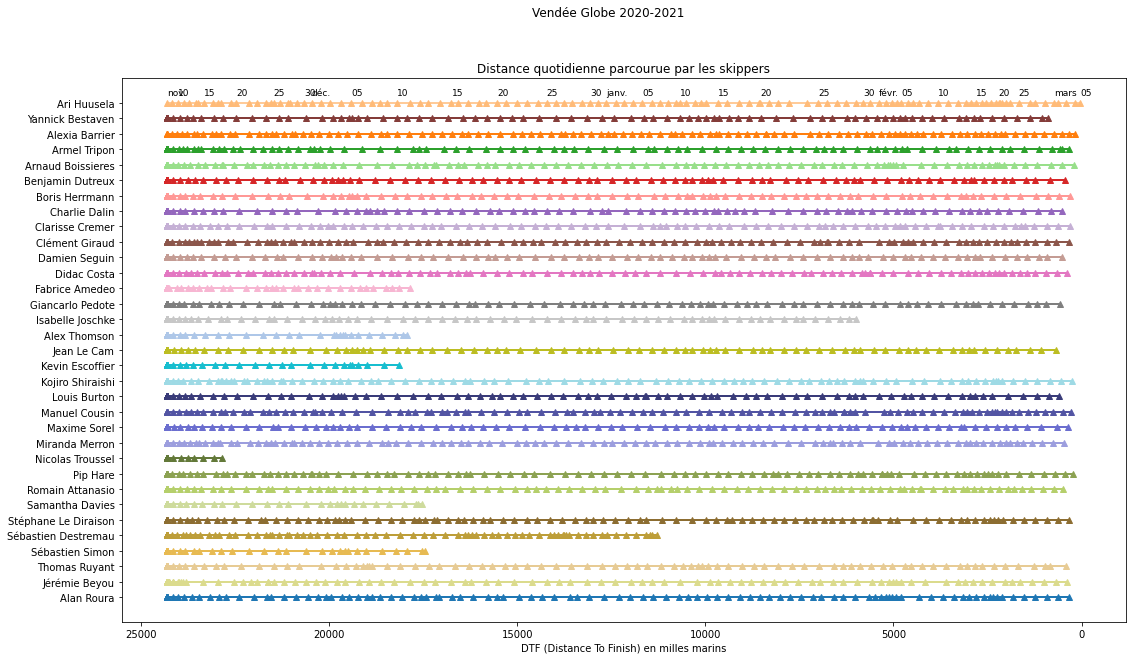

In [28]:
# Visualisation de la distance parcourue par voilier et par jour

# pretty date
def pretty_date(dt, timeframe):

    # print mois
    if (dt.day == 1) or (dt == timeframe[0]):
        return dt.strftime('%b')

    # print jour
    elif ((dt.day % 5) == 0)  or (dt == timeframe[-1]):
        return dt.strftime('%d')

    # pass
    return ''

def show_race(df):        

    # calcul de la distance parcourue (DTF max - DTF courant)
    tab = df.groupby(['skipper', 'date'])['DTF'].mean().unstack('skipper')
    _max = tab.max().max()
    tab = tab.fillna(_max)
    # on prend le max par jour
    tab = tab.resample('D').max()
    tab = tab.reset_index(drop=True)
    tab.loc[0] = _max
    # on trie selon la distance actuelle
    tab = tab.sort_values(tab.index[-1], ascending=False, axis=1)

    # figure
    fig, ax = plt.subplots(figsize=(18,10))
    fig.suptitle('Vendée Globe 2020-2021')
    ax.set_title('Distance quotidienne parcourue par les skippers')
    colors = df.set_index('skipper')['color'].to_dict()
    for i, (skipper, ser) in enumerate(tab.iteritems()):
        ax.plot(ser, [i] * len(ser), marker='^', color=colors[skipper])

    # print dates
    timeframe = df.set_index('date').resample('D').size().index
    days = [pretty_date(dt, timeframe) for dt in timeframe]
    for i, x in enumerate(tab.iloc[:,-1]):
        ax.annotate(days[i], (x, tab.shape[1]-0.5), fontsize=9)

    # labels des x
    ax.set_xlabel('DTF (Distance To Finish) en milles marins')
    ax.invert_xaxis()
    # labels des y
    ax.set_yticks(range(len(tab.columns)))
    ax.set_yticklabels(tab.columns)
    
show_race(df_course)

### 5. Quelques cartes

**Commentaires** :
- Les cartes des projets utilisant `ipyleaflet`, `folium`, `plotly` ou d'autres librairies sont bien plus réussies que celles réalisées avec `matplotlib`.
   - Ne pas hésiter à horodater vos cartes dans le titre.
- Il subsiste cependant une difficulté concernant le passage de l'antiméridien (de +180° à -180°) afin d'éviter d'afficher des routes qui traversent tout le planisphère d'est en ouest.
    - On peut s'en tirer en éclatant les données de route en sous-routes sans dépassement d'un écart arbitraire entre deux longitudes successives (300° par exemple).

#### 5.1 Carte avec un seul voilier

- On affiche le parcours d'un seul skipper depuis le début de la course en utilisant les longitudes et latitudes successives. On utilise la projection cylindrique équidistante qui déforme les pôles.
- Pour améliorer la visualisation, on affiche également les côtes des continents terrestres. On utilise les données des côtes qui sont disponibles sur le site : https://www.naturalearthdata.com/

In [29]:
# Carte avec un seul voilier

# imports
from matplotlib.patches import Path
from matplotlib.collections import PathCollection

import shapefile

# gestion du passage à l'antiméridien +180° -180°
# fonction réutilisée dans la plupart des cartes
def split_points(points, longitude_index=0, gap=300):
    # test sur les écarts si dépassement du gap en longitude
    test = np.abs(points[:, longitude_index] - np.roll(points[:, longitude_index], 1)) > gap
    test[0] = False  # à cause du roll

    # split des points en sous-ensembles sans dépassement du gap
    indices_to_split = np.where(test)[0]  # indices pour le split
    sub_points = np.split(points, indices_to_split)
    
    return sub_points


# show route
def show_route(skipper):
    
    # load shape file with coastlines
    sf = shapefile.Reader('ne_110m_coastline/ne_110m_coastline.shp')
    
    fig, ax = plt.subplots(figsize=(16, 8))
    # limites du graphique
    ax.set_xlim(left=-180, right=180)  # longitude de -180° à +180°
    ax.set_ylim(bottom=-90, top=90)  # latitude de -90° à +90°
    
    # titre
    # horodatage
    dt = df_all['date'].max().strftime('%A %d %B %Y à %Hh')
    # rang
    last_index = df_all.loc[df_all['rang']==1].index[-1]
    last_df = df_all.iloc[last_index:]
    last_df = last_df.loc[last_df['skipper']==skipper, 'rang']
    rang = 'RET' if last_df.empty else last_df.values[0]
    s = '' if last_df.empty else ('er' if rang == 1 else 'ème')
    ax.set_title(f'Vendée Globe au {dt}\nparcours de {skipper} ({rang}{s})')
    
    # affichage des côtes
    # shape.points est une liste de tuples (longitude, latitude)
    cotes = [Path(np.array(shape.points)) for shape in sf.shapes()]
    p = PathCollection(cotes, edgecolors='k', facecolors='none')
    ax.add_collection(p)

    # color
    colors = df_all.set_index('skipper')['color'].to_dict()
    color = colors[skipper]

    # calcul de la route
    points = df_all.loc[df_all['skipper']==skipper, ['longitude', 'latitude']].values
    sub_points = split_points(points)
    
    # routes
    routes = [Path(ps) for ps in sub_points]
    p = PathCollection(routes, edgecolors=color, facecolors='none', lw=2)
    ax.add_collection(p)

    plt.axis('off')

In [30]:
# affichage du parcours d'un skipper

# dropdown columns
first = df_course.loc[df_course['rang']==1, 'skipper'].values[-1]
skipper = widgets.Dropdown(options=sorted(df_all['skipper'].unique()),
                            value=first,
                            description='Skipper :',
                           )
# interaction
widgets.interact(show_route, skipper=skipper);

interactive(children=(Dropdown(description='Skipper :', index=8, options=('Alan Roura', 'Alex Thomson', 'Alexi…

#### 5.2 Carte avec plusieurs voiliers

- On généralise la carte précédente en affichant les routes de plusieurs voiliers donnés sous la forme d'une liste.
- On en a profité pour rajouter un paramètre "window" permettant de zoomer sur la zone.

Il est possible de comparer avec la carte fournie par les organisateurs de la course : https://www.vendeeglobe.org/fr/cartographie

In [31]:
# show routes
def show_routes(df, skippers, window=5):
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # limites du graphique
    if window is not None:
        xmin = df['longitude'].min() - window
        xmax = df['longitude'].max() + window
        ymin = df['latitude'].min() - window
        ymax = df['latitude'].max() + window
        color = 'lightgrey'
    else:
        xmin, xmax, ymin, ymax = -180, 180, -90, 90
        color = 'none'
        
    ax.set_xlim(left=xmin, right=xmax)
    ax.set_ylim(bottom=ymin, top=ymax)
    
    # titre
    ax.set_title('Vendée Globe au {}'.format(df['date'].max().strftime('%A %d %B %Y à %Hh')))

    # affichage des côtes
    # shape.points est une liste de tuples (longitude, latitude)
    sf = shapefile.Reader('ne_110m_coastline/ne_110m_coastline.shp')
    cotes = [Path(np.array(shape.points)) for shape in sf.shapes()]
    p = PathCollection(cotes, edgecolors='k', facecolors=color)
    ax.add_collection(p)

    # colors
    colors = df.set_index('skipper')['color'].to_dict()

    # affichage des routes
    for skipper in skippers:
        points = df_all.loc[df_all['skipper']==skipper, ['longitude', 'latitude']].values
        sub_points = split_points(points)

        routes = [Path(ps) for ps in sub_points]
        color = colors[skipper]
        p = PathCollection(routes, edgecolors=color, facecolors='none', lw=2)
        ax.add_collection(p)

    plt.axis('off')
    
    return ax

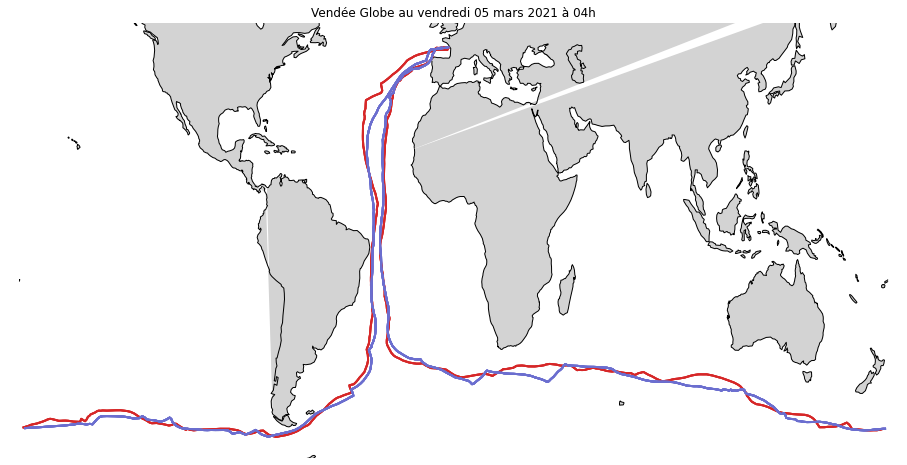

In [32]:
# affichage de plusieurs voiliers
n = 10
top = df_course.loc[df_course['rang']<=n, 'skipper'].values[-n:]
ax = show_routes(df_course, top)

#### 5.3 Carte en projection sinusoïdale

- On transforme la carte en une projection sinusoïdale qui déforme moins les pôles.

$\begin{cases}
x = \lambda.cos(\phi)\\
y = \lambda
\end{cases}$
où $\phi$ est la longitude et $\lambda$ est la latitude exprimées en radians.

In [33]:
# Carte en une projection sinusoidale
# x = longitude × cos(latitude)
# y = latitude

def geo2rad(long_lat):
    long_lat_rad = np.deg2rad(long_lat)
    return long_lat_rad[0] * np.cos(long_lat_rad[1]), long_lat_rad[1]

# show
def show_vendee_globe(df):
    # load shape file with coastlines
    sf = shapefile.Reader('ne_110m_coastline/ne_110m_coastline.shp')

    fig, ax = plt.subplots(figsize=(16, 8))
    # limites du graphique
    xmin, xmax = -np.pi, np.pi
    ymin, ymax = -np.pi/2, np.pi/2
    ax.set_xlim(left=xmin, right=xmax)  # longitude de -π à +π
    ax.set_ylim(bottom=ymin, top=ymax)  # latitude de -π/2 à +π/2

    # titre
    ax.set_title('Vendée Globe au {}'.format(df['date'].max().strftime('%A %d %B %Y à %Hh')))

    # affichage des côtes
    # shape.points est une liste de tuples (longitude, latitude)
    # application de geo2rad aux différents points de chaque shape
    cotes = [Path(np.apply_along_axis(geo2rad, 1, np.array(shape.points))) for shape in sf.shapes()]
    p = PathCollection(cotes, edgecolors='k', facecolors='none')
    ax.add_collection(p)

    # colors
    colors = df.set_index('skipper')['color'].to_dict()
    
    # affichage des routes
    for skipper in df['skipper'].unique():
        points = df_all.loc[df_all['skipper']==skipper, ['longitude', 'latitude']].values
        sub_points = split_points(points)

        routes = [Path(np.apply_along_axis(geo2rad, 1, ps)) for ps in sub_points]
        color = colors[skipper]
        p = PathCollection(routes, edgecolors=color, facecolors='none', lw=2)
        ax.add_collection(p)
    
    plt.axis('off');

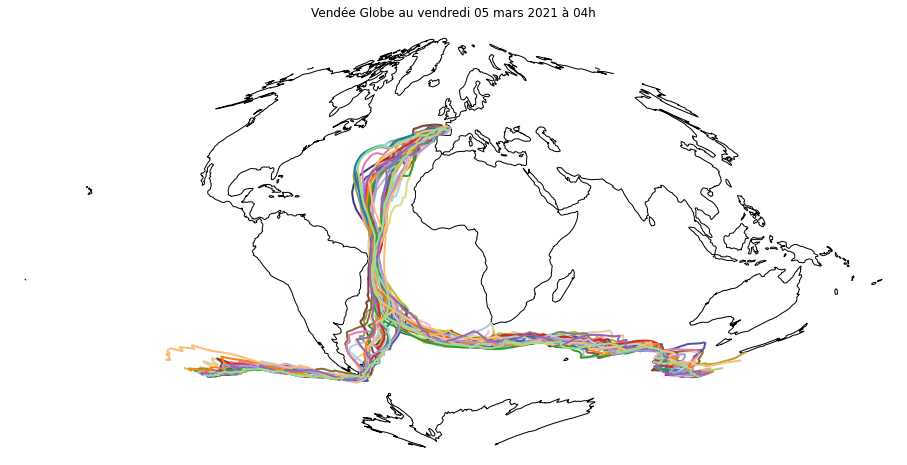

In [34]:
# show vendee globe
show_vendee_globe(df_course)

#### 5.4 Carte avec ant paths et vents

Carte avec ant paths et vents.

In [35]:
# carte des vents

# imports
from ipyleaflet.velocity import Velocity
import xarray as xr

if not os.path.exists('wind-global.nc'):
    url = 'https://github.com/benbovy/xvelmap/raw/master/notebooks/wind-global.nc'
    import requests
    r = requests.get(url)
    wind_data = r.content
    with open('wind-global.nc', 'wb') as f:
        f.write(wind_data)

with xr.open_dataset('wind-global.nc') as ds:
    display_options = {
    'velocityType': 'Global Wind',
    'displayPosition': 'bottomleft',
    'displayEmptyString': 'No wind data'
    }
    wind = Velocity(data=ds,
                    zonal_speed='u_wind',
                    meridional_speed='v_wind',
                    latitude_dimension='lat',
                    longitude_dimension='lon',
                    velocity_scale=0.01,
                    max_velocity=20,
                    display_options=display_options)

In [36]:
# carte avec visualisation des vents

# imports
import random
from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker, AntPath, CircleMarker, Popup, AwesomeIcon, projections, LayersControl, LayerGroup
from ipywidgets import HTML

def add_route(m, skipper, color, df):
    # random color
    col = "#%06x" % random.randint(0, 0xFFFFFF)
    
    # affichage de la route
    points = df.loc[df['skipper']==skipper, ['latitude', 'longitude']].values
    subpoints = split_points(points, longitude_index=1)
    
    for ps in subpoints:
        path = AntPath(locations=ps.tolist(), color=col)
        layer_group = LayerGroup(name=skipper, layers=(path,))
        m.add_layer(layer_group)

    # affichage du marker pour le dernier segment
    marker = CircleMarker(location=subpoints[-1].tolist()[-1], color=col, radius=5)
    marker.popup = HTML(skipper)
    layer_group = LayerGroup(name=skipper, layers=(marker,))
    m.add_layer(layer_group)
    

def generate_map(df):
    skipper_list = df["skipper"].unique().tolist()
    skipper_list.sort()
    m = Map(
        basemap=basemap_to_tiles(basemaps.Esri.WorldImagery),
        center=(25, 2),
        zoom=1,
        close_popup_on_click=True
        )
    
    # color
    colors = df.set_index('skipper')['color'].to_dict()
    
    # affichage des routes des skippeurs
    for skipper in skipper_list:
        color = tuple([int(255 * c) for c in colors[skipper]])
        color = '#%02x%02x%02x' % color
        add_route(m, skipper, color, df)

    control = LayersControl(position='topright')
    m.add_control(control)
    m.add_layer(LayerGroup(name='Vents', layers=(wind,)))
    return m

generate_map(df_course)

Map(center=[25, 2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

#### 5.5 Carte en projection orthographique

Carte en projection orthographique.

In [37]:
# carte en projection orthographique

# imports
import plotly.express as px
import plotly.graph_objects as go

dt = df_course['date'].max().strftime('%A %d %B %Y à %Hh')

fig = px.line_geo(df_course.sort_values(['skipper', 'date']), lat='latitude', lon='longitude', hover_name="skipper",
                    hover_data={'skipper': False, 'date': True, 'VMG': True},
                    color='skipper', projection='orthographic')

fig.update_layout(showlegend = True,
                    height=500,
                    title_text = f'Vendée Globe en projection orthographique<br />au {dt}',
                    geo = dict(
                        showland = True,
                        showcountries = True,
                        showocean = True,
                        countrywidth = 0.5,
                        landcolor = 'tan',
                        lakecolor = 'aliceblue',
                        oceancolor = 'aliceblue',
                        lonaxis = dict(
                            showgrid = True,
                            gridcolor = 'rgb(102, 102, 102)',
                            gridwidth = 0.5),
                        lataxis = dict(
                            showgrid = True,
                            gridcolor = 'rgb(102, 102, 102)',
                            gridwidth = 0.5)))

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)

f = go.FigureWidget(fig)
f

FigureWidget({
    'data': [{'customdata': array([['Alan Roura', Timestamp('2020-11-08 14:00:00'), 12.9],
    …

## 6. Méthodes statistiques et machine learning

Non mis en oeuvre dans ce corrigé partiel.

**Commentaires** :
- De nombreux projets ont impémenté des méthodes statistiques ou de machine learning pour détecter la présence d'un foil, pour prendre en compte le nombre de participations, pour deviner le prochain classement, pour estimer l'impact des caractéristiques techniques des voiliers, etc.
    - Lors de la mise en oeuvre d'algorithmes de machine learning, il faut systématiquement calculer la performance de votre modèle (par ex., accuracy, precision, recall, f1-score, AUC...).
    - Pour les heatmaps avec `seaborn`, la colormap par défaut tirant sur les rouges et les jaunes n'est pas très esthétique. Utiliser plutôt des nuanciers monochromes comme `Blues`, `Greens` ou `Reds`.

## 7. Dashboard avec <code>Voilà</code>

Une fois le notebook terminé, il est possible de l'afficher sous la forme d'un dashboard esthétique en utilisant la librairie <code>Voilà</code>, voir https://voila.readthedocs.io/en/stable/index.html

L'installation de <code>Voilà</code> s'effectue simplement avec <code>pip</code> ou <code>conda</code>, et ensuite il suffit de lancer <code>Voilà</code> à partir d'un terminal en ligne de commande pour visualiser le notebook sous la forme d'un dashboard sans code Python visible.